In [80]:
import numpy as np
import matplotlib.pyplot as pyplot
from matplotlib.path import Path
import matplotlib.patches as patches

In [172]:
class HMM_Simulator(object):
    
    def __init__(self, map_size, obs_size):
        
        #### Defining parameters and variables ####
        ## Probability of robot staying in the same state
        self.p_stay = 0.2
        # Probability of robot observing given state correctly
        self.p_truesignal = 0.7
        # Size of the gridworld
        self.map_size = map_size # Size of one edge of grid world
        self.state_size = map_size * map_size # Total number of state
        self.obs_size = obs_size # Total number of observation
        # Noise of the robot
        
        # Transition matrix of the simulator, initilize without any obstacles
        # Size is num_state x num_state
        self.T = np.zeros((self.state_size, self.state_size))
        
        # Observation matrix of the simulator, num_state x num_obs
        self.M = np.zeros((self.state_size, self.obs_size))
        
        # True identity of the states, the index corresponds to the state
        self.S_type = np.random.choice(self.obs_size, self.state_size)
        
        # Keep track of any obstacles
        self.obstacles = [3, 10, 20]
        ## First classify the states into different types
        self.corner_states = [0, self.map_size - 1, 
                         self.state_size - self.map_size, self.state_size - 1]
        self.north_edge_states = list(range(1, self.map_size-1))
        self.west_edge_states = list(range(self.map_size, self.state_size - self.map_size, 
                                      self.map_size))
        self.east_edge_states = list(range(self.map_size*2-1, self.state_size - self.map_size, 
                                      self.map_size))
        self.south_edge_states = list(range(self.state_size - self.map_size - 1, self.state_size - 1))
        self.middle_states = sorted(list(set(range(self.map_size-1)) - \
                                         set(self.corner_states) - \
                                         set(self.north_edge_states) - \
                                         set(self.west_edge_states) - \
                                         set(self.east_edge_states) - \
                                         set(self.south_edge_states)))
        
        
        #### Updating the matrices according to the map ####
        
        # Fill in the transition matrix
        ## Second iterate through all the states and fill the transition matrix
        ### Determine corner case
        for s in self.corner_states:
            prow = np.zeros(self.state_size)
            prow[s] = self.p_stay + (1.0 - self.p_stay) / 2
            if s == 0:
                prow[1] = (1.0 - self.p_stay) / 4.0
                prow[self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.map_size-1):
                prow[self.map_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.state_size - self.map_size - 1):
                prow[self.state_size - 2*self.map_size] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - 2*self.map_size + 1] = (1.0 - self.p_stay) / 4.0
            else:
                prow[self.state_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - self.map_size - 1] = (1.0 - self.p_stay) / 4.0
                
            self.T[s,:] = prow
            
            
        for s in range(self.state_size):
            if s in self.corner_states:
                continue;
            prow = np.zeros(self.state_size)
            if s in self.north_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.east_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.west_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.south_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
            else:
                prow[s] = self.p_stay
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            
            self.T[s,:] = prow
        
        # Fill in the observation matrix
        for i in range(self.state_size):
            m_row = np.array([0.7 if k == self.S_type[i] else 
                              0.3/(self.obs_size-1) for k in range(self.obs_size)])
            self.M[i,:] = m_row
        
        
    # Generate data randomly, robot will go to any station uniformly
    # and observe the state according to M matrix
    # Return the true state locations and the observation at give time t
    def random_generate(self, N):
        non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))
        Z = np.zeros(N)
        X = np.random.choice(non_obstacles, N)
        for t in range(N):
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[X[t],:])
            
        return (X, Z)
            
    # Generate the data according to the transition matrix,
    # The robot moves one state at a time and observe one observation at a time
    # Return the true state locations and the observation at given time t
    # Robot starts at a random location
    def noramal_generate(self, N):
        Z = np.zeros(N)
        X = np.zeros(N)
        non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))
        current_state = np.random.chocie(non_obstacles, 1)
        for t in range(N):
            current_state = np.random.choice(list(range(self.state_size), 1, p=self.T[current_state,:]))
            X[t] = current_state
            Z[t] = Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[X[current_state],:])
        
        return (X, Z)
    
    # Generate the data when there is correlation between more than one past states
    # to the next movement
    def corr_generate(self, N):
        return
    
    # Fill the world with random obstacles of given size
    # Adjust T and M accordingly
    def fill_random_obstacle(self, N):
        return
    
    # Show the map
    def draw_world(self):
        fig = pyplot.figure()
        ax = fig.add_subplot(111)

        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False)

        size = 10
        for i in range(self.map_size+1):
            ax.plot([0,self.map_size*size],[i*size,i*size],'k-')

        for i in range(self.map_size+1):
            ax.plot([i*size,i*size],[0,self.map_size*size],'k-')
        
        for s in self.obstacles:
        # Draw the obstacles
            x = s % self.map_size
            y = self.map_size - s // self.map_size -1
            verts = [
                (x*size,y*size),
                (x*size,(y+1)*size),
                ((x+1)*size,(y+1)*size),
                ((x+1)*size,y*size),
                (x*size,y*size),
            ]

            codes = [Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
             ]

            path = Path(verts, codes)

            patch = patches.PathPatch(path, facecolor='black', lw=1)
            ax.add_patch(patch)
            
        for s in range(self.state_size):
            if s not in self.obstacles:
                x = s % self.map_size
                y = self.map_size - s // self.map_size -1
                name = self.S_type[s]
                ax.text((x+0.4)*size, (y+0.45)*size, name)
        
        pyplot.show()
        

In [173]:
h = HMM_Simulator(6, 4)

In [174]:
h.random_generate(10)

(array([19, 35,  9,  6, 18, 19, 33, 12, 19,  0]),
 array([2., 1., 0., 3., 2., 1., 2., 0., 2., 0.]))

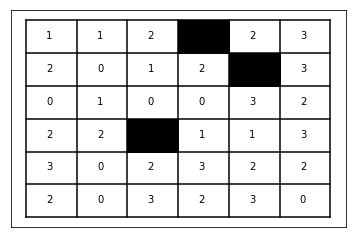

In [175]:
h.draw_world()

array([1, 1, 2, 0, 2, 3, 2, 0, 1, 2, 3, 3, 0, 1, 0, 0, 3, 2, 2, 2, 0, 1,
       1, 3, 3, 0, 2, 3, 2, 2, 2, 0, 3, 2, 3, 0])